# FD004

In [19]:
!wget https://ti.arc.nasa.gov/c/6/ -O data.zip
!unzip data.zip
!pip install lifelines

--2021-04-30 16:56:26--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2021-04-30 16:56:26--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  11.85M  3.55MB/s    in 3.5s    

2021-04-30 16:56:30 (3.39 MB/s) - ‘data.zip’ saved [12425978/12425978]

Archive:  data.zip
replace Damage Propagation Modeling.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001

In [20]:
# load necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter
%matplotlib inline

In [21]:
inputdir = ""

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Preparing datasets

In [22]:
# the files did not contain headers. Here we create labels based on documentation
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]
column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
df_train= pd.read_csv(inputdir+'train_FD004.txt', sep=" ", header=None, names = column_names)
df_test = pd.read_csv(inputdir+'test_FD004.txt', sep=" ", header=None, names = column_names)

# drop NULL columns
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)

display(df_train)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,8312.35,1.02,41.68,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,7994.94,0.93,36.48,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,404.59,2319.66,8840.16,1.27,46.08,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,567.59,2388.47,9117.12,1.31,48.04,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,569.04,2388.51,9126.53,1.31,48.24,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,199.93,2223.78,8403.64,1.05,42.53,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774


# Adding Failure indicators and Cycle starts

In [23]:
df_train["IsFailure"] = 0
idx_failure = (np.where(df_train["Cycle"] ==1)[0] - 1)[1:]
df_train["IsFailure"][idx_failure] = 1
df_train["CycleStart"] = df_train["Cycle"]-1
df_train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,0
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,0,1
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,0,2
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,8312.35,1.02,41.68,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,0,3
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,7994.94,0.93,36.48,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,404.59,2319.66,8840.16,1.27,46.08,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,0,250
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,567.59,2388.47,9117.12,1.31,48.04,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,0,251
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,569.04,2388.51,9126.53,1.31,48.24,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,0,252
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,199.93,2223.78,8403.64,1.05,42.53,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,0,253


In [24]:
drop_sensors = op_settings_columns +['Sensor_1','Sensor_5','Sensor_6','Sensor_10','Sensor_16','Sensor_18','Sensor_19']
X = df_train.drop(labels=drop_sensors, axis=1)
X

,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,549.68,1343.43,1112.93,137.36,2211.86,8311.32,41.69,129.78,2387.99,8074.83,9.3335,330,10.62,6.3670,0,0
1,1,2,606.07,1477.61,1237.50,332.10,2323.66,8713.60,43.94,312.59,2387.73,8046.13,9.1913,361,24.37,14.6552,0,1
2,1,3,548.95,1343.12,1117.05,138.18,2211.92,8306.69,41.66,129.62,2387.97,8066.62,9.4007,329,10.48,6.4213,0,2
3,1,4,548.70,1341.24,1118.03,137.98,2211.88,8312.35,41.68,129.80,2388.02,8076.05,9.3369,328,10.54,6.4176,0,3
4,1,5,536.10,1255.23,1033.59,174.82,1915.22,7994.94,36.48,164.11,2028.08,7865.80,10.8366,305,14.03,8.6754,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,605.33,1516.36,1315.28,404.59,2319.66,8840.16,46.08,380.16,2388.73,8185.69,8.4541,372,29.11,17.5234,0,250
61245,249,252,643.42,1598.92,1426.77,567.59,2388.47,9117.12,48.04,535.02,2388.46,8185.47,8.2221,396,39.38,23.7151,0,251
61246,249,253,643.68,1607.72,1430.56,569.04,2388.51,9126.53,48.24,535.41,2388.48,8193.94,8.2525,395,39.78,23.8270,0,252
61247,249,254,555.77,1381.29,1148.18,199.93,2223.78,8403.64,42.53,187.92,2388.83,8125.64,9.0515,337,15.26,9.0774,0,253


In [25]:
df_test["IsFailure"] = 0
idx_failure = (np.where(df_test["Cycle"] ==1)[0] - 1)[1:]
df_test["IsFailure"][idx_failure] = 1
df_test["CycleStart"] = df_test["Cycle"]-1
X_test = df_test[X.columns]
X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,606.67,1481.04,1227.81,332.52,2323.67,8704.98,43.83,313.03,2387.78,8048.98,9.2229,362,24.31,14.7007,0,0
1,1,2,536.22,1256.17,1031.48,174.46,1915.21,7999.94,36.11,163.61,2028.09,7863.46,10.8632,306,14.36,8.5748,0,1
2,1,3,549.23,1340.13,1105.88,137.34,2211.93,8305.38,41.52,129.98,2387.95,8071.13,9.3960,328,10.39,6.4365,0,2
3,1,4,549.19,1339.70,1107.26,137.23,2211.89,8301.00,41.73,129.48,2387.90,8078.89,9.3594,328,10.56,6.2367,0,3
4,1,5,555.10,1353.04,1117.80,192.94,2222.71,8331.05,41.32,181.82,2387.87,8057.83,9.3030,333,14.85,8.9326,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,550.30,1364.40,1129.17,138.34,2212.35,8351.73,42.30,130.87,2388.50,8112.61,9.4427,331,10.53,6.2620,0,276
41210,248,278,608.00,1494.75,1260.88,334.75,2324.23,8758.69,44.53,314.51,2388.33,8086.83,9.2772,366,24.33,14.6486,0,277
41211,248,279,555.92,1370.65,1130.97,194.92,2223.57,8370.49,42.33,182.76,2388.64,8100.84,9.3982,336,14.69,8.8389,0,278
41212,248,280,608.19,1489.11,1256.25,333.15,2324.19,8753.04,44.78,314.17,2388.37,8085.24,9.2727,366,24.44,14.6887,0,279


In [26]:
from lifelines import CoxPHFitter
cph = CoxTimeVaryingFitter()

cph.fit(X, id_col='UnitNumber', event_col='IsFailure', start_col='CycleStart', stop_col='Cycle')
cph.print_summary() 

<lifelines.CoxTimeVaryingFitter: fitted with 61249 periods, 249 subjects, 248 events>
         event col = 'IsFailure'
number of subjects = 249
 number of periods = 61249
  number of events = 248
partial log-likelihood = -603.18
  time fit was run = 2021-04-30 16:56:41 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    1.45       4.27       0.20             1.05             1.85                 2.86                 6.38
Sensor_3    0.09       1.10       0.02             0.06             0.13                 1.06                 1.14
Sensor_4    0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04
Sensor_7   -0.06       0.94       0.13            -0.32             0.20                 0.72                 1.23
Sensor_8   -1.13       0.32       0.11            -1.35            -0.91                 0.26                 0.40
Sensor_9    0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04
Sensor_11   3.56      35.13       0.56             2.45             4.67                11.61               106.32
Sensor_12  -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.26
Sensor_13   0.76       2.13       0.08             0.59             0.92                 1.81                 2.51
Sensor_14  -0.01       0.99       0.01            -0.04             0.02                 0.97                 1.02
Sensor_15  -2.19       0.11       0.91            -3.96            -0.41                 0.02                 0.66
Sensor_17   0.43       1.53       0.07             0.29             0.57                 1.33                 1.76
Sensor_20   1.60       4.93       0.58             0.46             2.73                 1.58                15.40
Sensor_21  -1.10       0.33       0.91            -2.87             0.68                 0.06                 1.97

               z      p   -log2(p)
covariate                         
Sensor_2    7.09 <0.005      39.46
Sensor_3    5.69 <0.005      26.22
Sensor_4    0.68   0.50       1.01
Sensor_7   -0.44   0.66       0.60
Sensor_8  -10.08 <0.005      76.93
Sensor_9    0.77   0.44       1.18
Sensor_11   6.30 <0.005      31.65
Sensor_12  -0.35   0.72       0.47
Sensor_13   9.06 <0.005      62.72
Sensor_14  -0.64   0.53       0.93
Sensor_15  -2.41   0.02       5.98
Sensor_17   6.05 <0.005      29.32
Sensor_20   2.75   0.01       7.38
Sensor_21  -1.21   0.23       2.14
---
Partial AIC = 1234.36
log-likelihood ratio test = 1041.49 on 14 df
-log2(p) of ll-ratio test = 706.61

In [27]:
#prediction
pred_cols = ['Cycle',
 'Sensor_2',
 'Sensor_3',
 'Sensor_4',
 'Sensor_7',
 'Sensor_8',
 'Sensor_9',
 'Sensor_11',
 'Sensor_12',
 'Sensor_13',
 'Sensor_14',
 'Sensor_15',
 'Sensor_17',
 'Sensor_20',
 'Sensor_21',
 'IsFailure',
 'CycleStart']

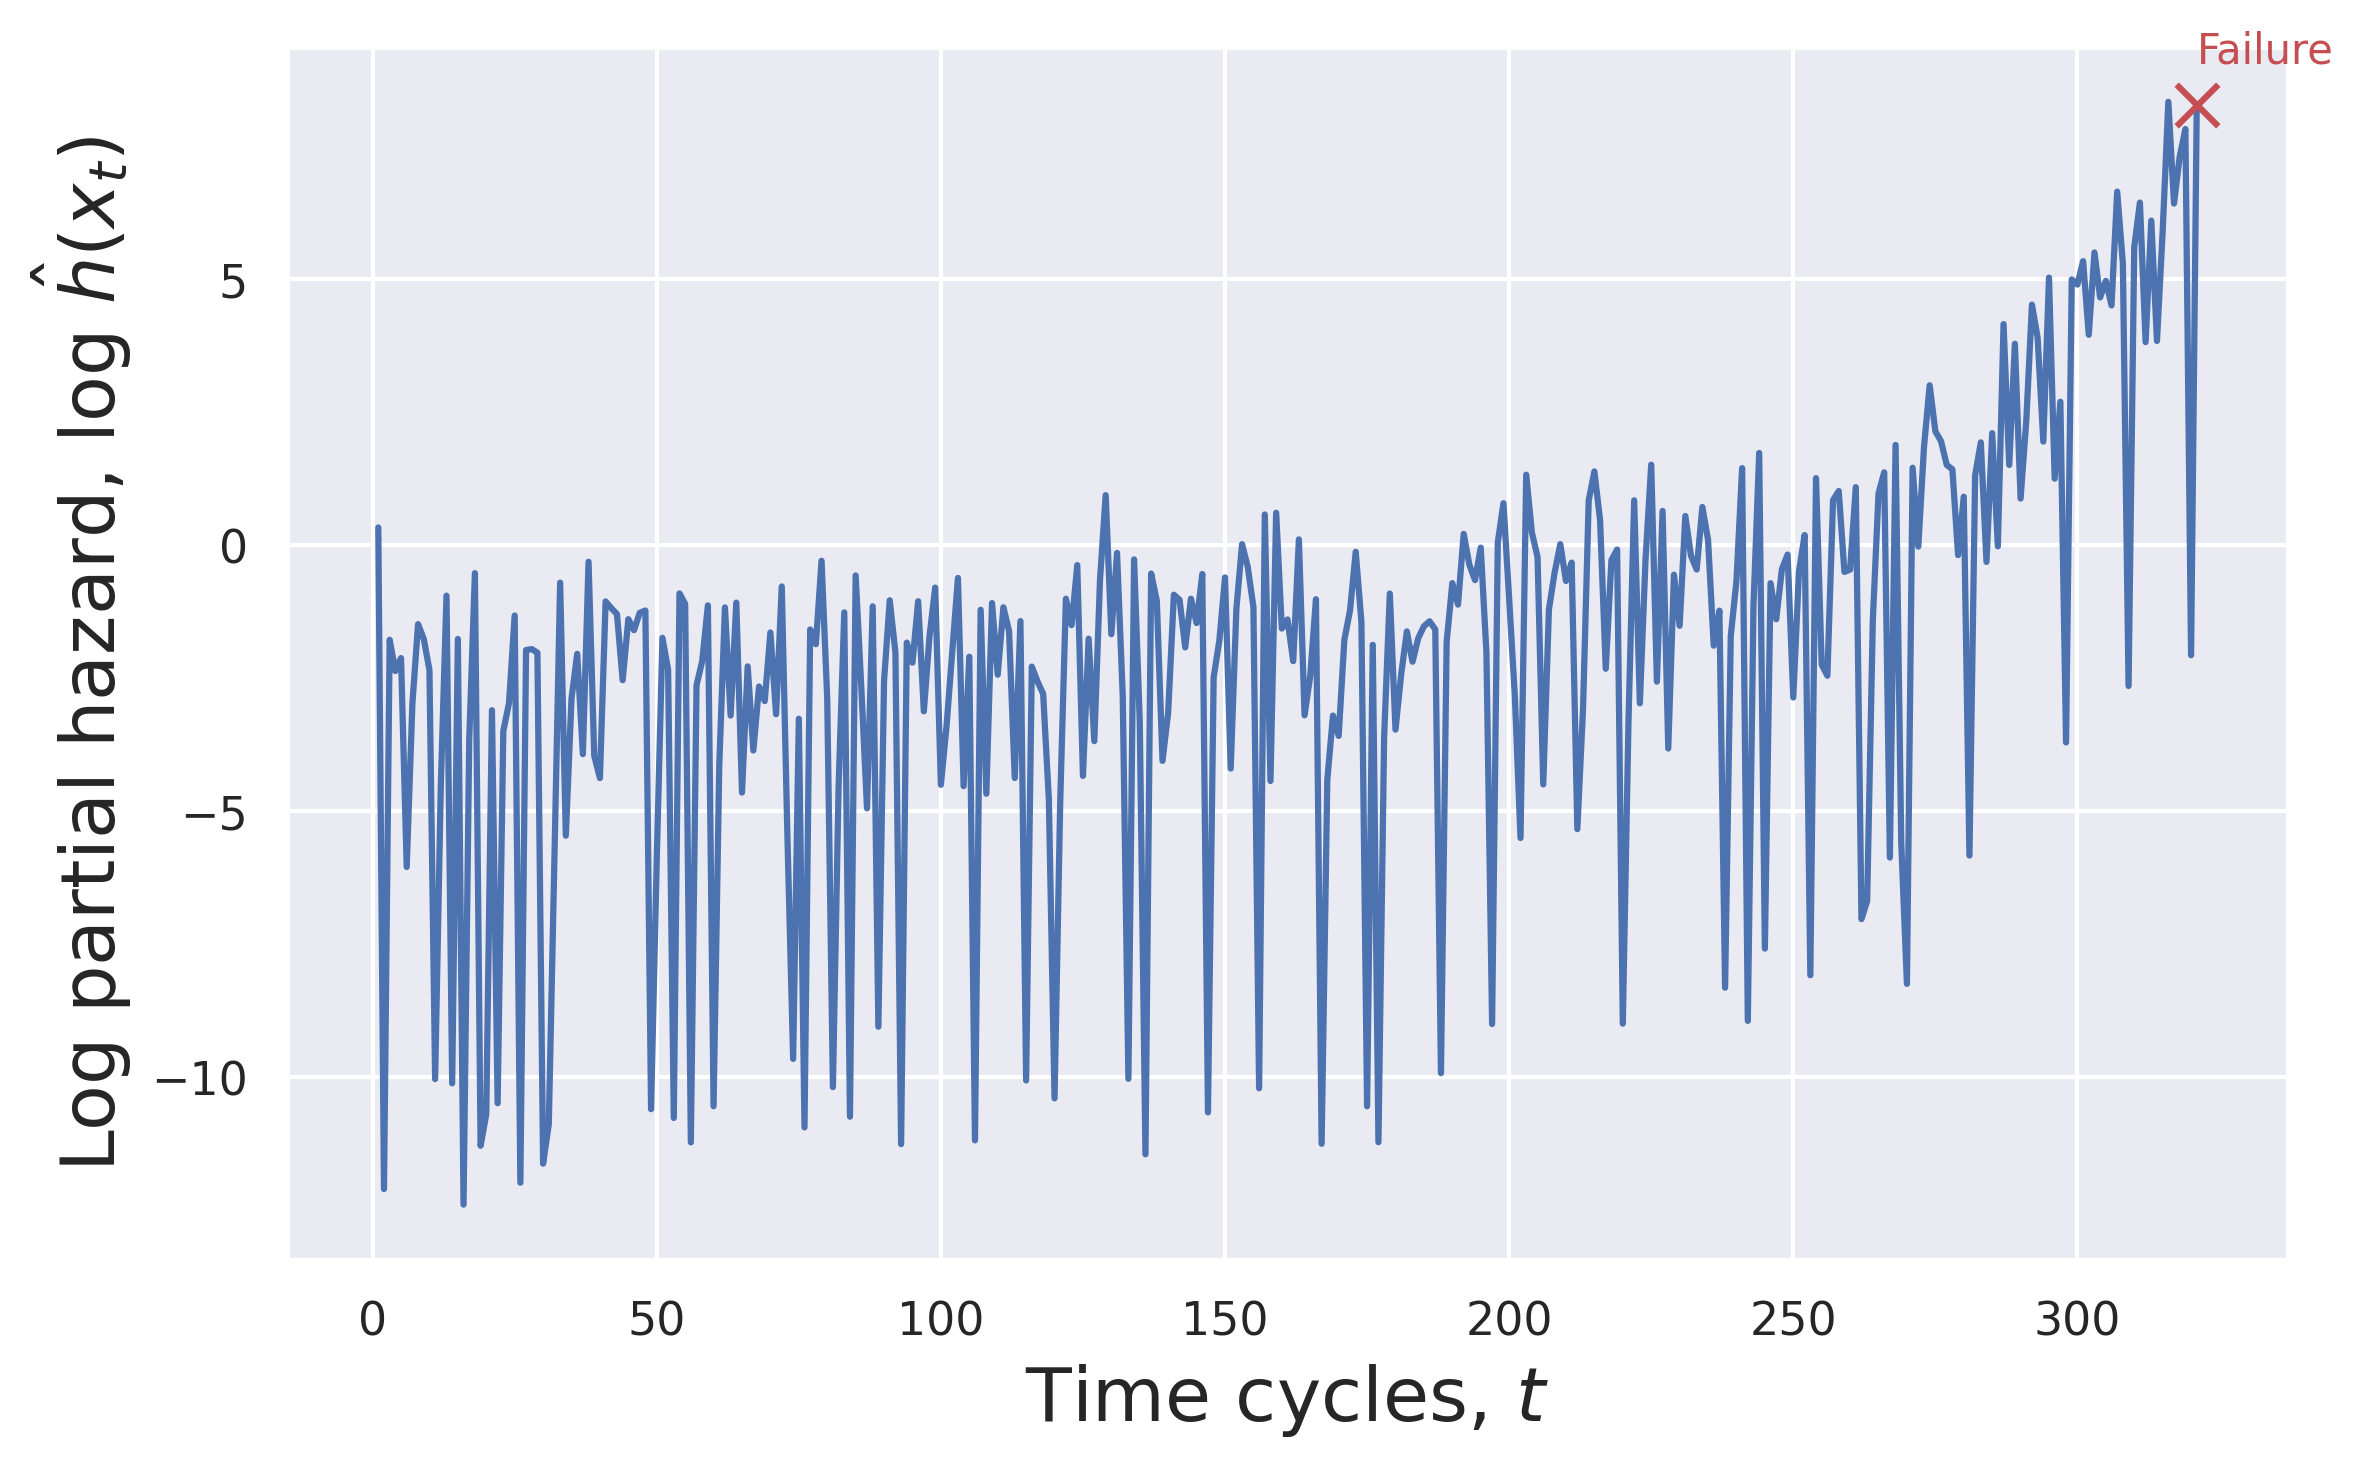

In [28]:
plt.figure(figsize=(8,5), dpi=300)


X_sub = X.loc[X['UnitNumber'] == 1]
predictions = cph.predict_partial_hazard(X_sub[pred_cols])
plt.plot(X_sub['Cycle'].values, np.log(predictions))
plt.scatter(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1], s=100, marker="x", zorder=10, c="C3")
plt.text(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]+0.8, "Failure", c="C3", fontsize=10)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.tight_layout()
plt.savefig('fd004_hazard_traj.pdf', format="pdf")
plt.show()
  

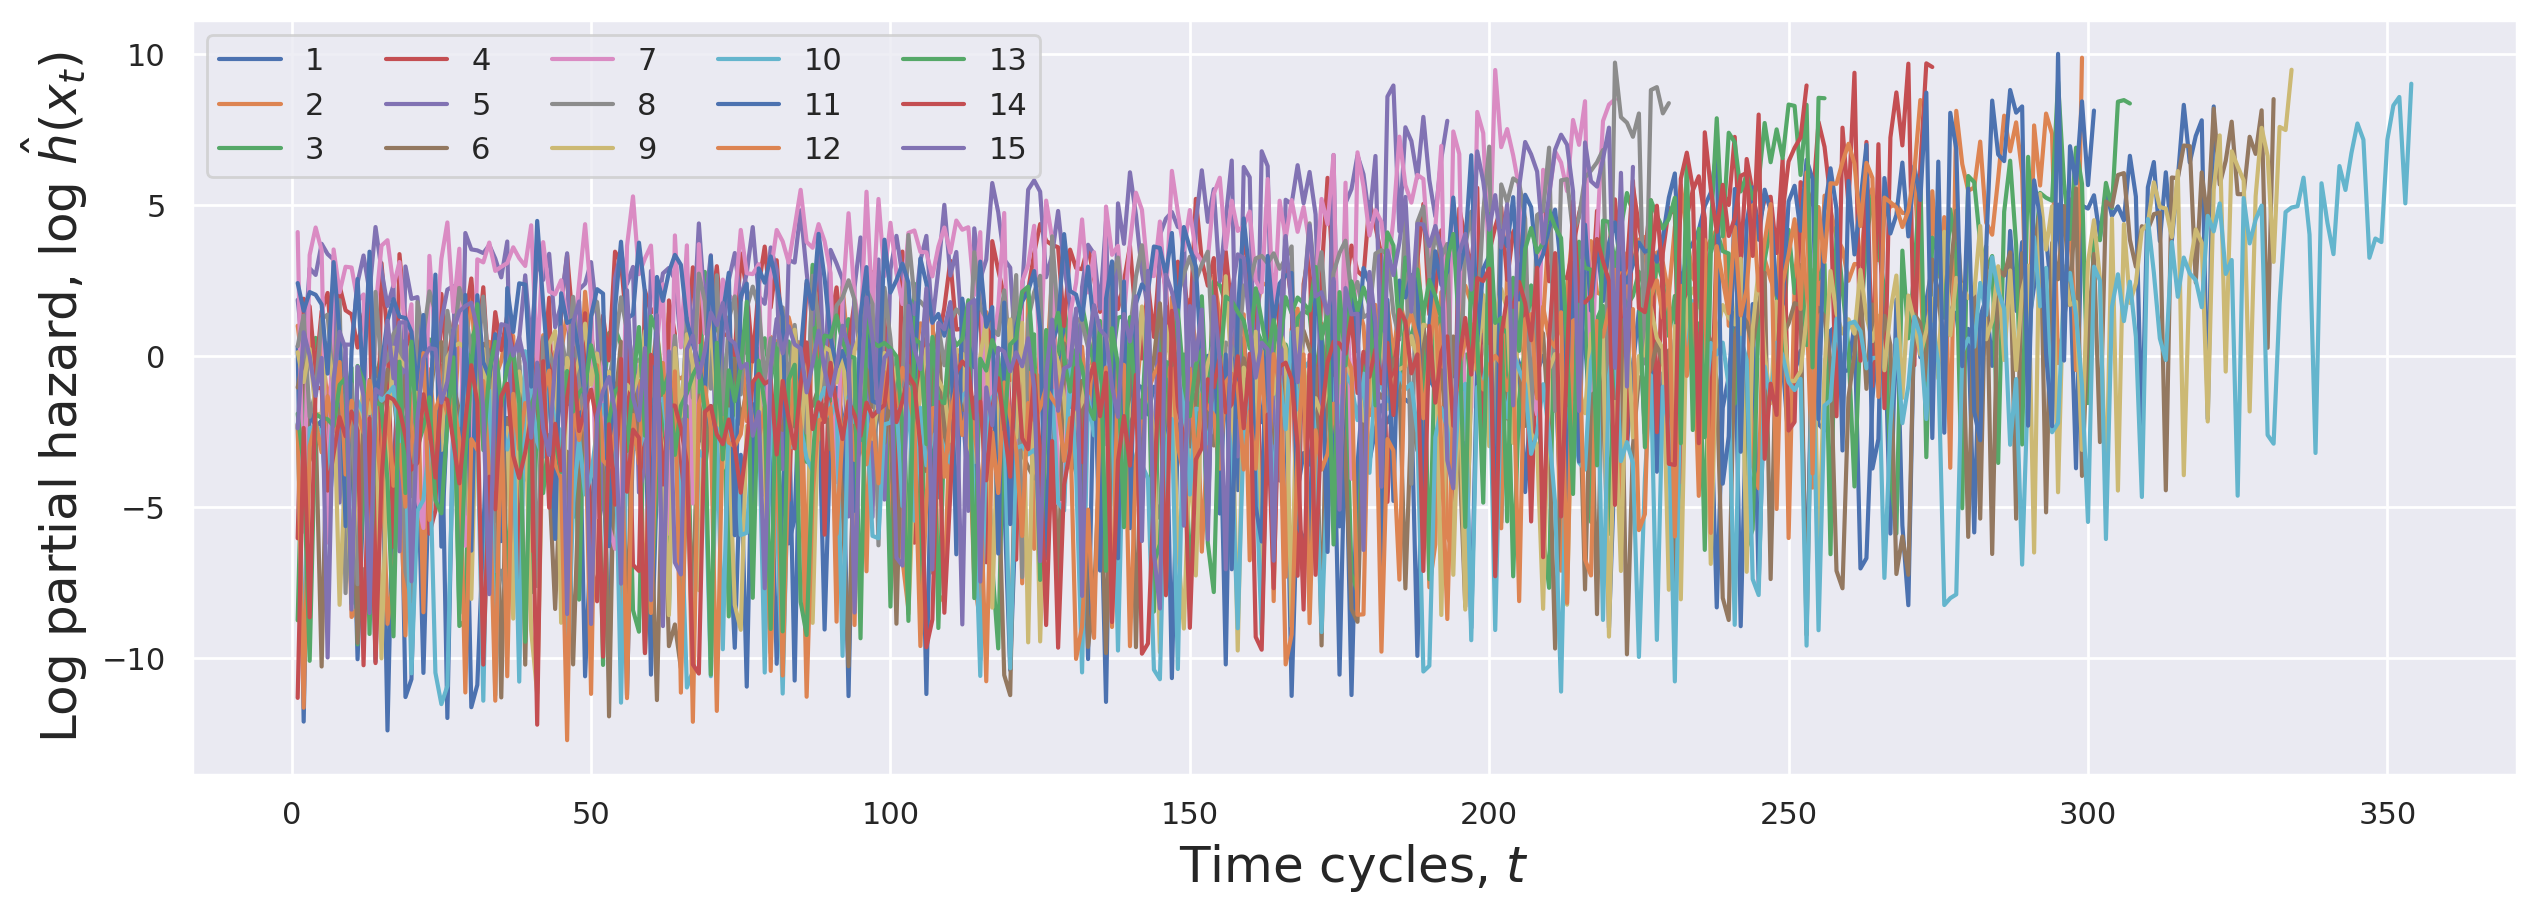

In [29]:
plt.figure(figsize=(15,5), dpi=200)

for i in trange(15):
    X_sub = X.loc[X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    plt.plot(X_sub['Cycle'].values, np.log(predictions), label=i+1)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.legend(ncol=5)
#plt.ylim([10, None])
plt.show()


# Thresholding the hazard score for decision making


In [30]:
#training

llp_replacement=4000000
perf_restoration=3500000

thres_list  = np.arange(6, 13, 1)


rep_num= 10
machine_num = 30

optim_data_mean = []
optim_data_std = []
for thres in thres_list :
  #simulate for rep_num times
  sim_results = []
  for k in trange(rep_num):
    #in each rep select machine_num machines
    machines = np.random.choice(X['UnitNumber'].unique(), size=machine_num)    
    machine_i = []
    for i in range(machine_num):
      X_sub = X.loc[X['UnitNumber'] == machines[i]]
      X_fail = X.loc[X['UnitNumber'] == machines[i]]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep
      
      machine_i.append([is_failed, total_perf_rest, total_llp_rep, total_maintcost])

    machine_i = np.array(machine_i)
    sim_result = [thres, machine_i[:, 0].mean(),  machine_i[:, 1].sum(),  
                  machine_i[:, 2].sum(),  machine_i[:, 3].sum()]
                  

    sim_results.append(sim_result)

  sim_results = np.array(sim_results)
  optim_data_mean.append(sim_results.mean(axis=0))
  optim_data_std.append(sim_results.std(axis=0))

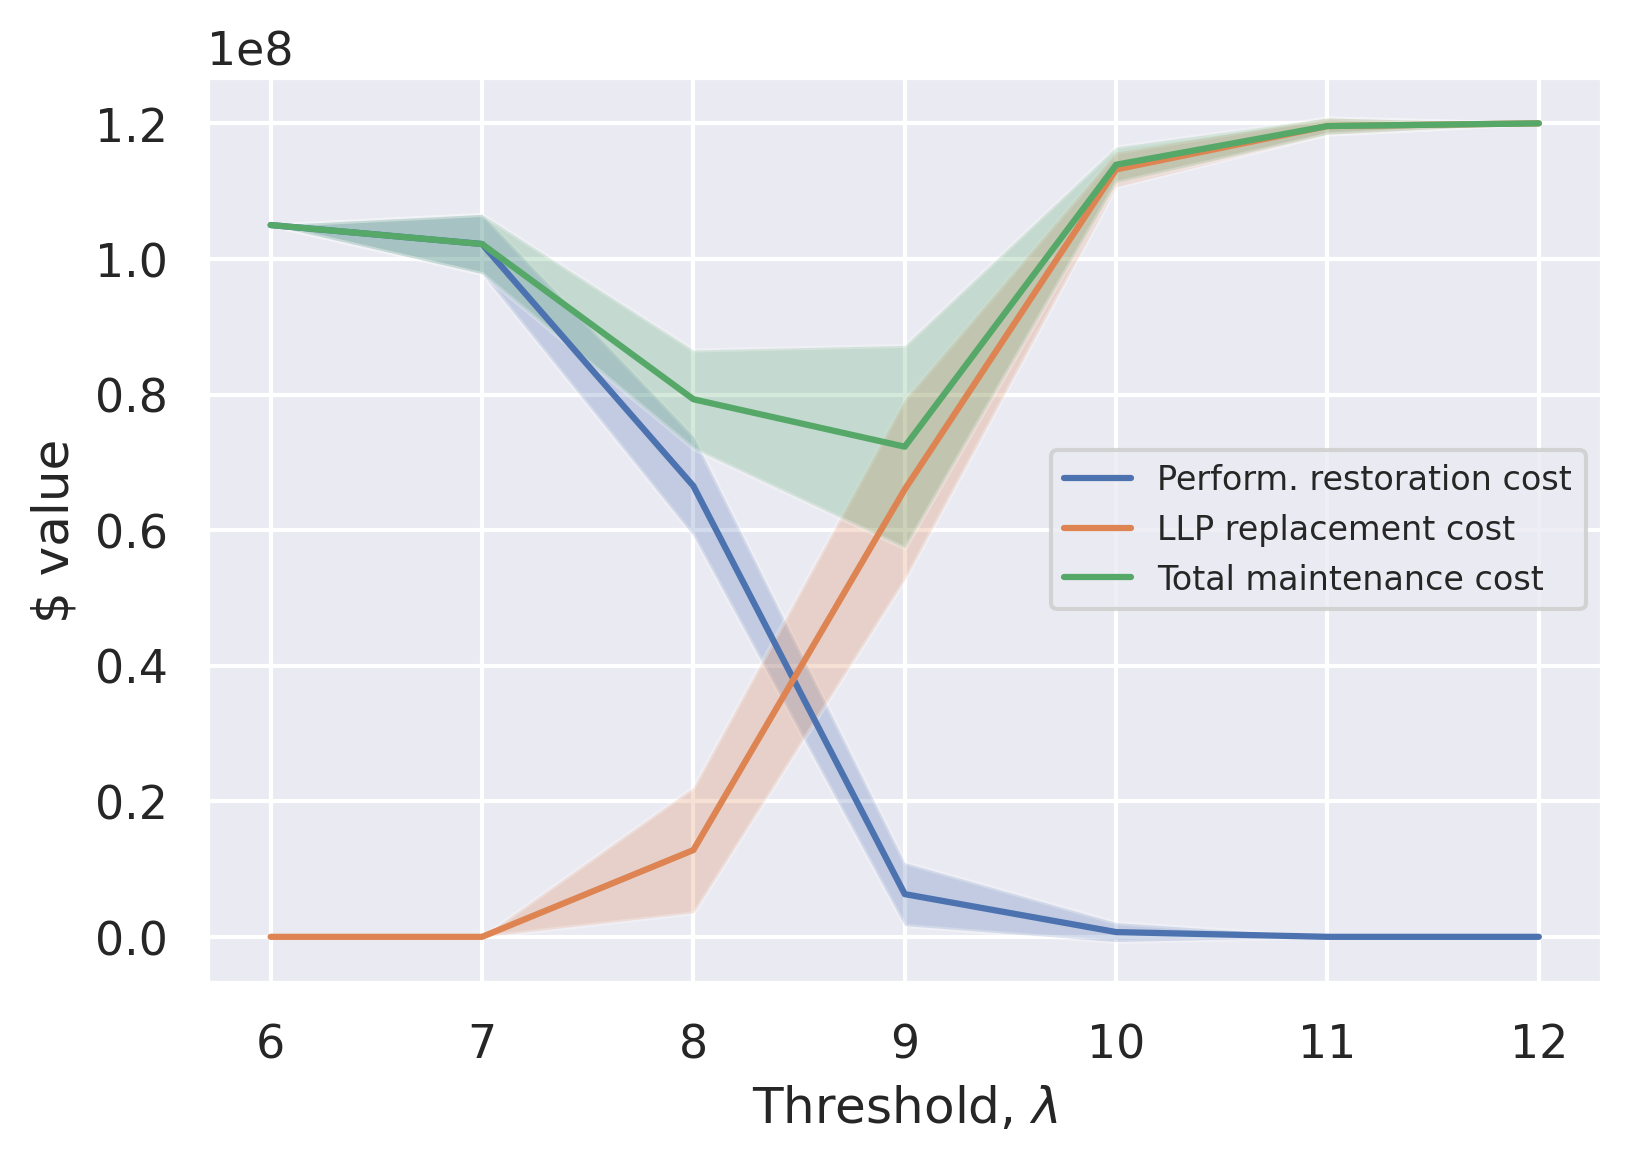

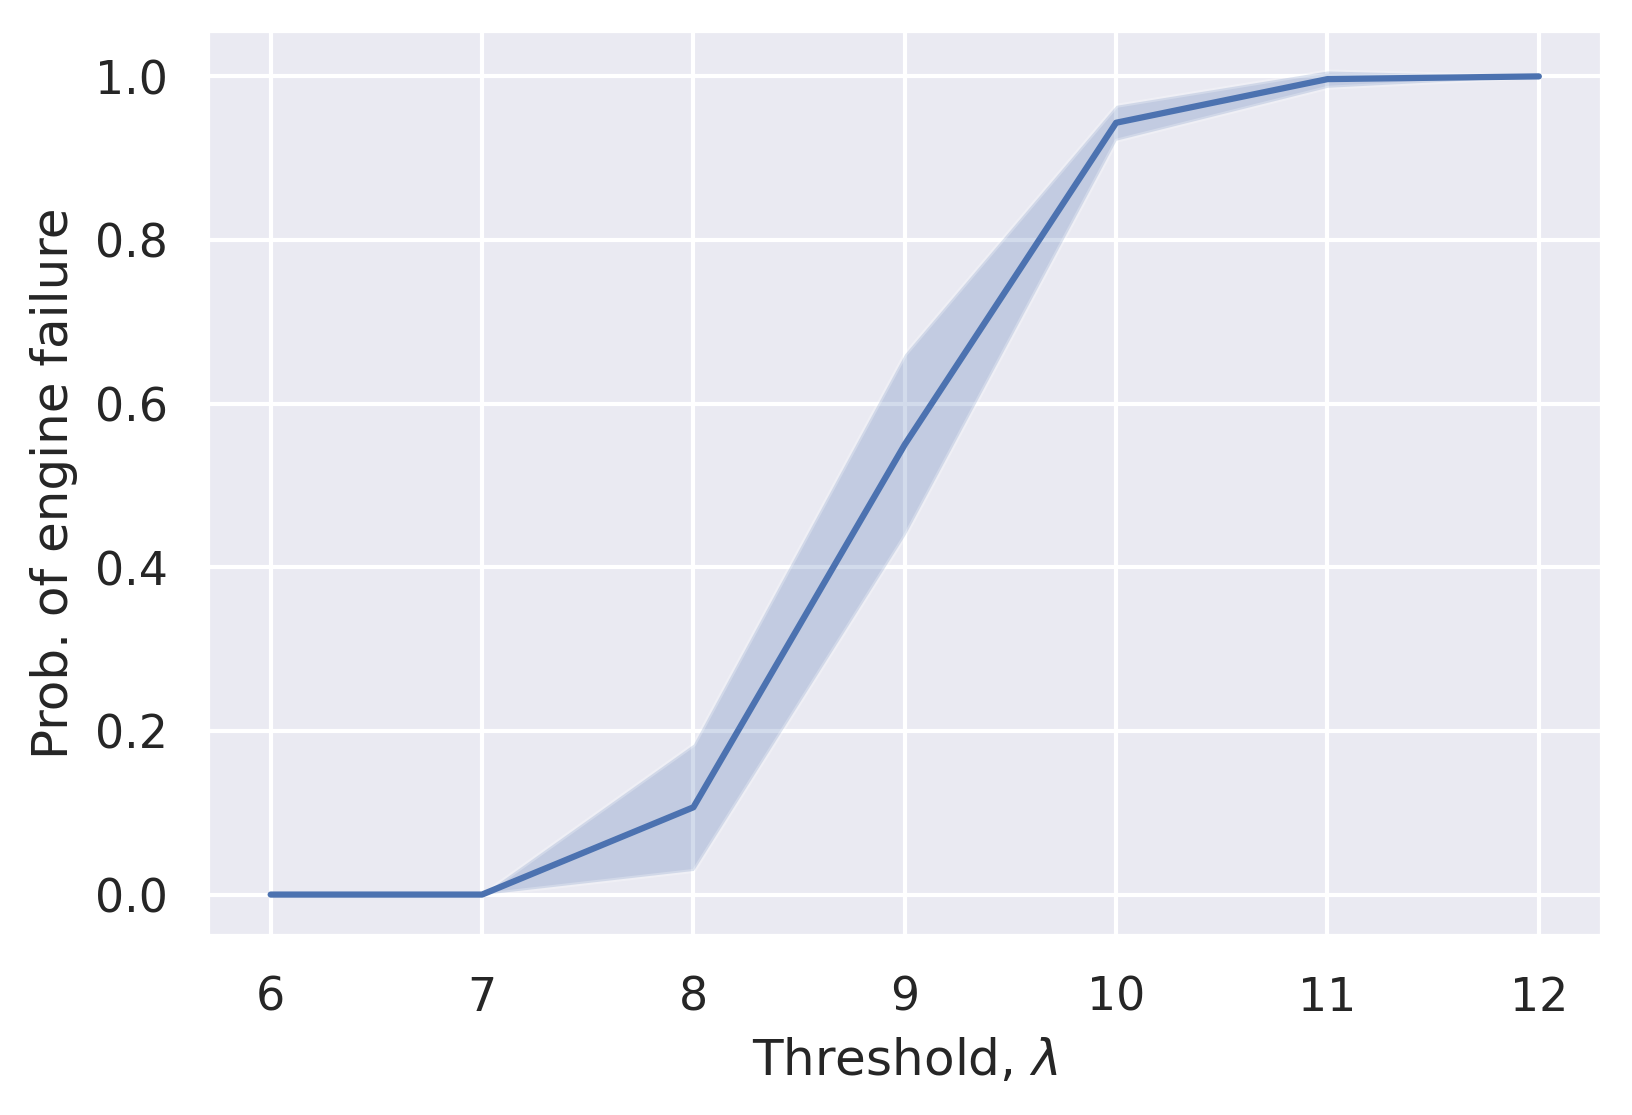

In [31]:
np.save('fd004_mean_', np.array(optim_data_mean))
np.save('fd004_std', np.array(optim_data_std))

mean_ = pd.DataFrame(np.array(optim_data_mean), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])
std_ = pd.DataFrame(np.array(optim_data_std), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])#

opt_thres_idx = mean_['maint_cost'].argmin()
opt_thres = thres_list[opt_thres_idx]

plt.figure(dpi=300)

plt.plot(thres_list, mean_['perf_rest'], label='Perform. restoration cost')
plt.fill_between(thres_list, mean_['perf_rest'] -std_['perf_rest'],  
                 mean_['perf_rest'] +std_['perf_rest'], alpha=0.25)

plt.plot(thres_list, mean_['llp_rep'], label='LLP replacement cost')
plt.fill_between(thres_list, mean_['llp_rep'] -std_['llp_rep'],  
                 mean_['llp_rep'] +std_['llp_rep'], alpha=0.25)

plt.plot(thres_list, mean_['maint_cost'], label='Total maintenance cost')
plt.fill_between(thres_list, mean_['maint_cost'] -std_['maint_cost'],  
                 mean_['maint_cost'] +std_['maint_cost'], alpha=0.25)

plt.xlabel('Threshold, $\lambda$')
plt.ylabel('$ value')
plt.legend( fontsize=8)
plt.savefig('fd004_cost.pdf', format="pdf")
plt.show()

plt.figure(dpi=300)
plt.plot(thres_list, mean_['fail_prob'], label='Engine failure probability')
plt.fill_between(thres_list, mean_['fail_prob'] -std_['fail_prob'],  
                 mean_['fail_prob'] +std_['fail_prob'], alpha=0.25)
plt.xlabel('Threshold, $\lambda$')
plt.ylabel('Prob. of engine failure')
plt.savefig('fd004_prob.pdf', format="pdf")
plt.show()


In [32]:
mean_

,thres,fail_prob,perf_rest,llp_rep,maint_cost
0,6.0,0.000000,105000000.0,0.0,105000000.0
1,7.0,0.000000,102200000.0,0.0,102200000.0
2,8.0,0.106667,66500000.0,12800000.0,79300000.0
3,9.0,0.550000,6300000.0,66000000.0,72300000.0
4,10.0,0.943333,700000.0,113200000.0,113900000.0
5,11.0,0.996667,0.0,119600000.0,119600000.0
6,12.0,1.000000,0.0,120000000.0,120000000.0


### Testing [We'll ignore this for now and focus on using training set]

In [33]:
#testing

machine_test_i = []
thres = opt_thres
for i in trange(X_test['UnitNumber'].max()):
      X_sub = X_test.loc[X_test['UnitNumber'] == i+1]
      X_fail = X_test.loc[X_test['UnitNumber'] == i+1]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep      
      machine_test_i.append([thres, is_failed, total_perf_rest, total_llp_rep, total_maintcost])

In [34]:
opt_thres

9

In [35]:
result_test = pd.DataFrame(np.array(machine_test_i), columns=['thres', 'is_failed', 'perf_rest', 'llp_rep', 'maint_cost'])
result_thres_test = result_test.groupby('thres').sum().reset_index()
result_thres_test['is_failed'] = result_thres_test['is_failed']/X_test['UnitNumber'].max()
result_thres_test


,thres,is_failed,perf_rest,llp_rep,maint_cost
0,9,0.995968,0,988000000,988000000


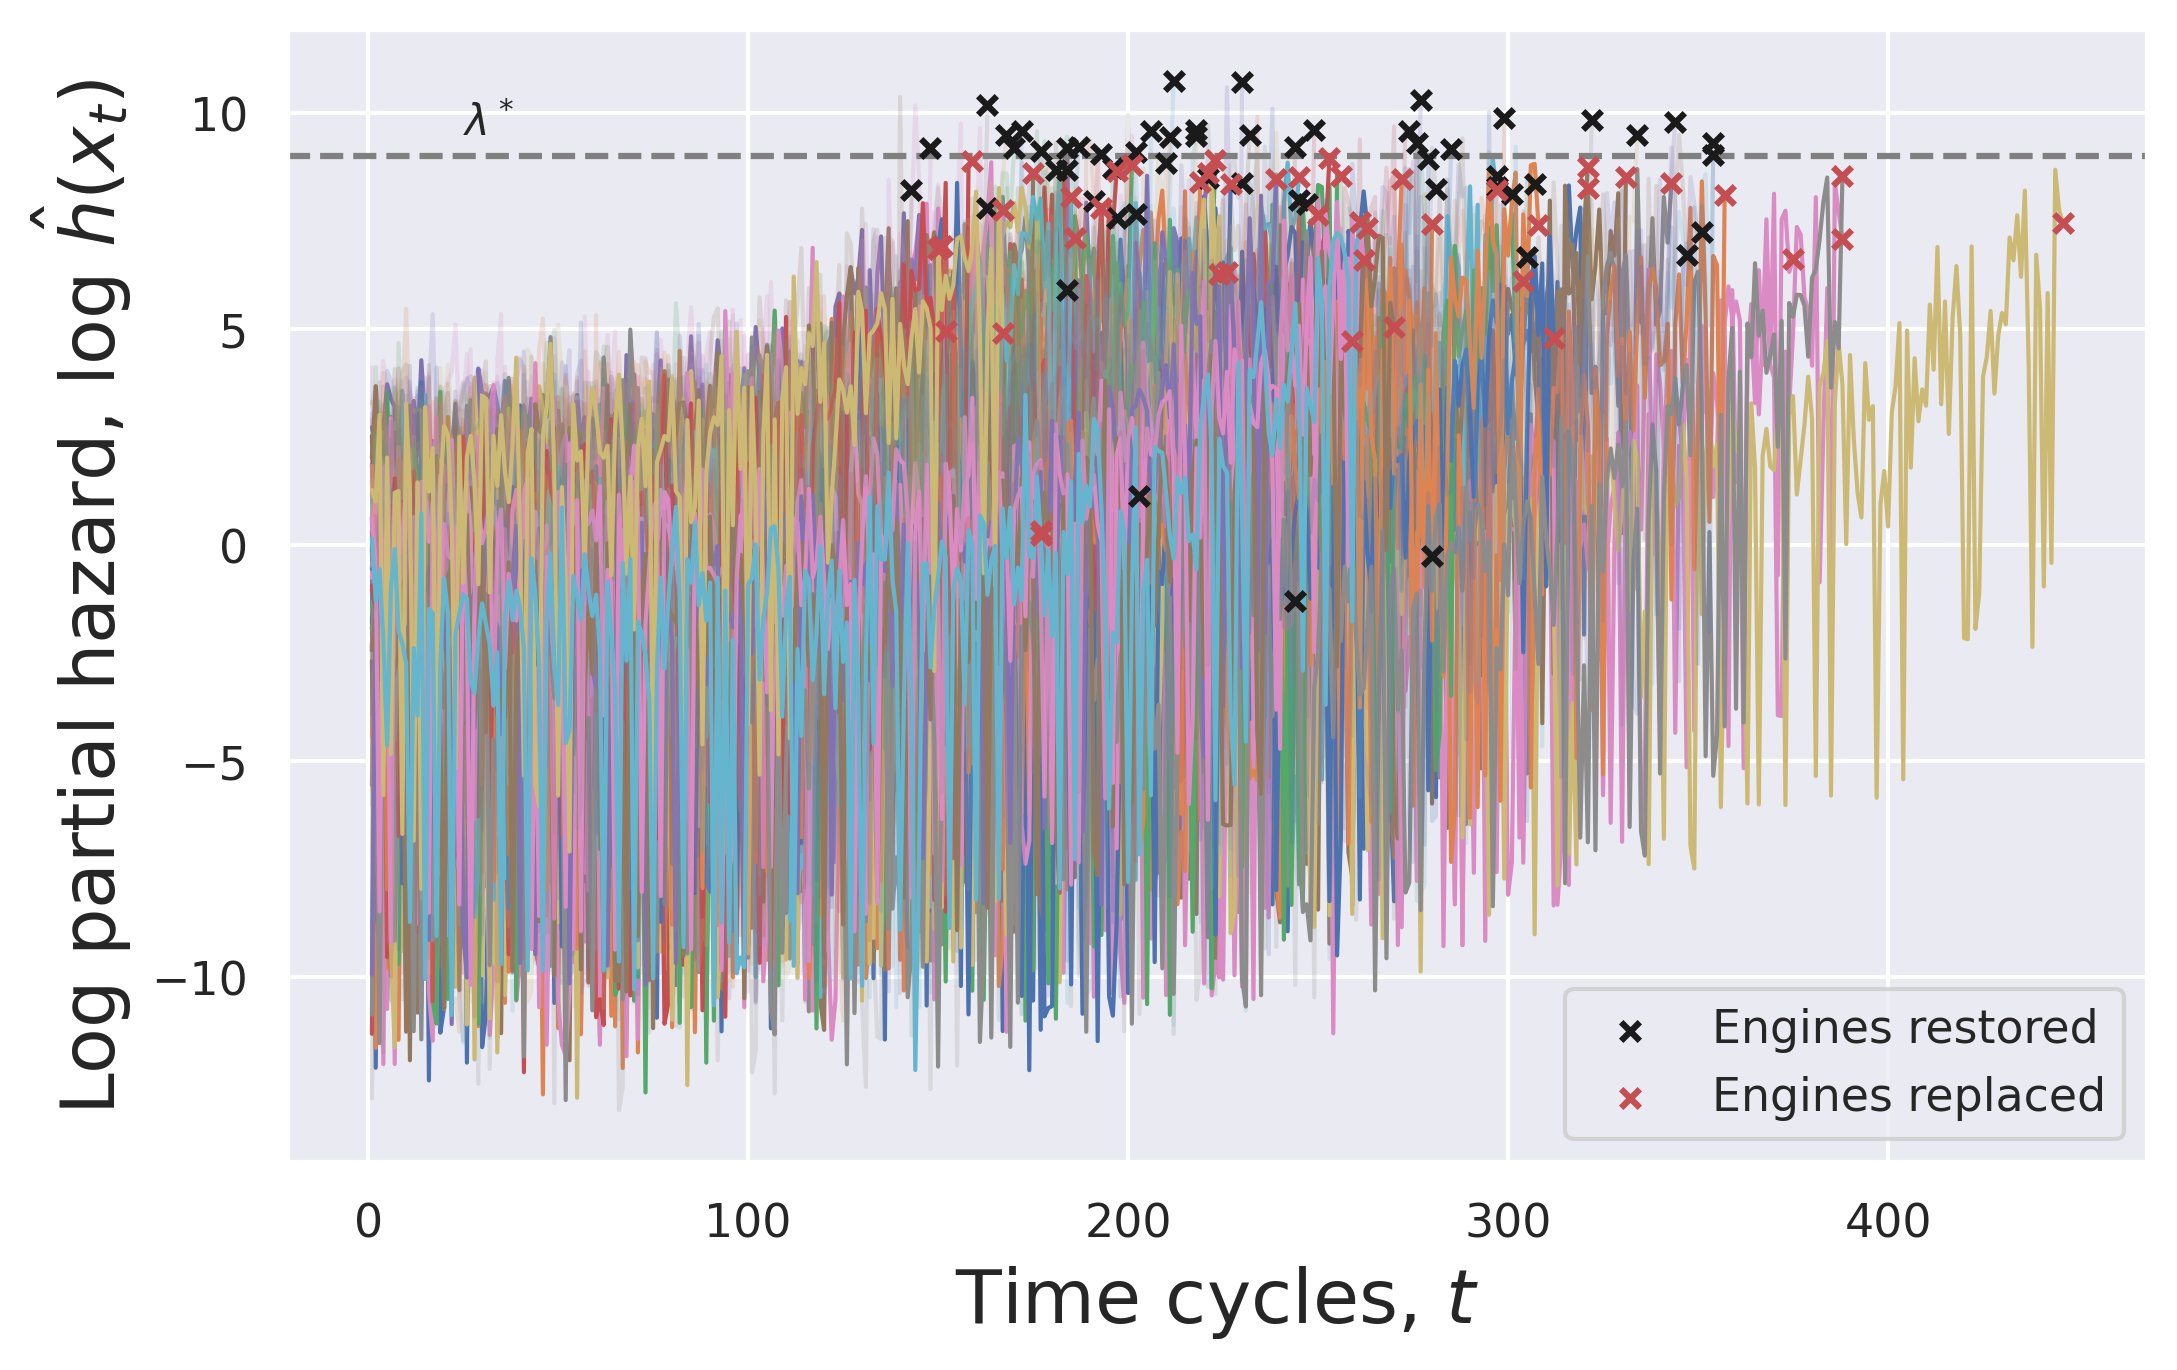

In [36]:
plt.figure(figsize=(8,5), dpi=300)
df_X = X
engines_restored = []
engines_replaced = []
for i in trange(100):
    X_sub = df_X.loc[df_X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    log_partial_hazard = np.log(predictions)
    is_maintained = log_partial_hazard.max() > thres
    plt.plot(X_sub['Cycle'].values, log_partial_hazard, alpha=0.2+0.8*~is_maintained, lw=1)
        
    if is_maintained:
      engines_restored.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])      
    else:
      engines_replaced.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])
engines_restored = np.array(engines_restored)
engines_replaced = np.array(engines_replaced)      

if len(engines_restored) > 0:
  plt.scatter(engines_restored[:, 0], engines_restored[:, 1], s=20, marker="x", zorder=10, c="k", label="Engines restored")  
if len(engines_replaced) > 0:
  plt.scatter(engines_replaced[:, 0], engines_replaced[:, 1], s=20, marker="x", zorder=10, c="r", label="Engines replaced")


plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.text(25, thres+0.5, '$\lambda^*$')
plt.legend()
plt.axhline(thres, c='gray', linestyle="dashed")
plt.savefig('sim_result_fd004.pdf', format="pdf")
plt.show()